<a href="https://colab.research.google.com/github/edwin-19/NLP-Framework-Comparison/blob/main/Spacy_Text_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import spacy
import pandas as pd

from sklearn.model_selection import train_test_split

import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

# Download data

In [2]:
reviews = pd.read_csv("https://raw.githubusercontent.com/hanzhang0420/Women-Clothing-E-commerce/master/Womens%20Clothing%20E-Commerce%20Reviews.csv")

In [18]:
reviews = reviews.dropna(subset=['Review Text'])
reviews.head(5)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,length
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,Absolutely wonderful - silky and sexy and comf...
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,Love this dress! it's sooo pretty. i happene...
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,I had such high hopes for this dress and reall...
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,"I love, love, love this jumpsuit. it's fun, fl..."
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,This shirt is very flattering to all due to th...


# EDA & Viz

In [22]:
reviews['length'] = reviews['Review Text'].apply(lambda x: len(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


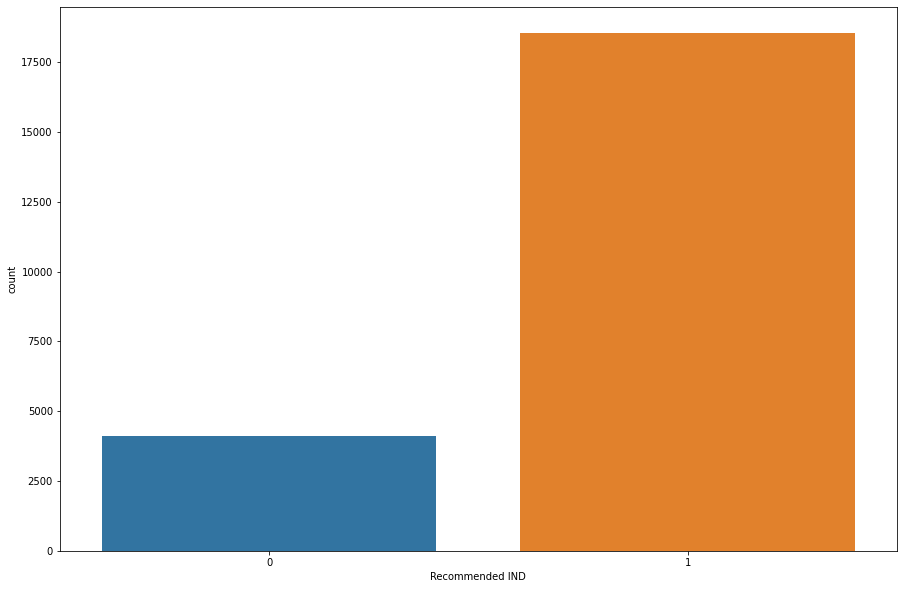

In [24]:
plt.figure(figsize=(15, 10))
sns.countplot(data=reviews, x='Recommended IND')

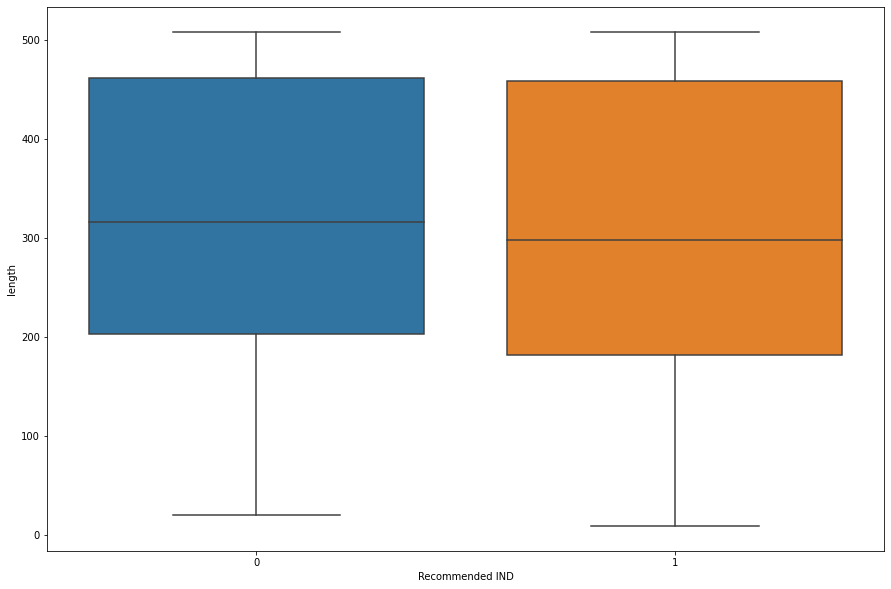

In [26]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=reviews, y='length', x='Recommended IND')

In [34]:
groups = reviews.groupby(['Recommended IND'])
for group in [0, 1]:
  get_id = groups.get_group(group).sample(1)
  print('ID: {}, Text: {}'.format(group, get_id['Review Text'].tolist()[0]))

ID: 0, Text: I typically wear a size 16/xl in anything from retailer and i ordered this top in an xl. it's more of a t-shirt with buttons than a blouse and it was overall too huge. it's nice to have extended size options but even if i went down to a size l, this would have looked like a maternity top on me.
ID: 1, Text: I saw this sweater and just about died. i loved the accentuated shoulders and beautiful knit detail on the sleeves. lucky for me, retailer day started a couple of days after this sweater debuted, and i snagged it right away. i just got it and am in love. it fits true to size and the shoulders and sleeves are everything i hoped they would be. the neckline in very flattering as well. it is soft and the color is gorgeous. if there is a negative, it would be that it is a bit boxy in the torso, and doe


# Load spacy pipelines

In [35]:
nlp = spacy.load("en_core_web_sm")
nlp.pipe_names

['tagger', 'parser', 'ner']

In [38]:
textcat = nlp.create_pipe("textcat", config={"exclusive_classes": True, "architecture": "simple_cnn"})
nlp.add_pipe(textcat, last=True)
nlp.pipe_names

['tagger', 'parser', 'ner', 'textcat']

In [39]:
textcat.add_label("POSITIVE")
textcat.add_label("NEGATIVE")

1

# Map data & Train

In [42]:
label_map = {0: 'NEGATIVE', 1: 'POSITIVE'}
reviews['Recommended IND'] = reviews['Recommended IND'].apply(lambda x: label_map[x])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [45]:
text = reviews['Review Text'].tolist()
labels = reviews['Recommended IND'].tolist()
train_text, test_text, train_labels, test_labels = train_test_split(text, labels, test_size=0.2, stratify=labels)
val_text, test_text, val_labels, test_labels = train_test_split(test_text, test_labels, test_size=0.5, stratify=test_labels)

In [48]:
def warp_data(text_data, label_data):
  data = []
  for text, label in zip(text_data, label_data):
    if label == 'NEGATIVE':
      label_negative = True
      label_pos = False
    else:
      label_negative = False
      label_pos = True

    tmp_label = {'cats': {'NEGATIVE': label_negative, 'POSITIVE': label_pos}}
    data.append((text, tmp_label))

  return data

In [49]:
train_data = warp_data(train_text, train_labels)
val_data = warp_data(val_text, val_labels)
test_data = warp_data(test_text, test_labels)

# Training Loop

In [79]:
from spacy.util import minibatch, compounding
from sklearn.metrics import accuracy_score, matthews_corrcoef

In [84]:
def evaluate():
  val_text_inf = [val[0] for val in val_data]

  y_pred = []
  preds = nlp.pipe(val_text_inf)
  for pred in tqdm(preds, total=len(val_text_inf)):
    tmp_pred = pred.cats
    pred = max(tmp_pred, key=tmp_pred.get)
    y_pred.append(pred)

  return {
      'acc': accuracy_score(y_pred, val_labels),
      'mcc': matthews_corrcoef(y_pred, val_labels)
  }

In [87]:
n_iters = 10
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
with nlp.disable_pipes(*other_pipes):  # only train textcat
    optimizer = nlp.begin_training()

    print("Training the model...")
    print('{:^5}\t{:^5}\t{:^5}'.format('LOSS', 'A', 'M'))

    # Performing training
    for i in tqdm(range(n_iters)):
        losses = {}
        batches = minibatch(train_data, size=compounding(4., 32., 1.001))
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, sgd=optimizer, drop=0.2, losses=losses)

        with textcat.model.use_params(optimizer.averages):
            scores = evaluate()

        print('{0:.3f}\t{1:.3f}\t{2:.3f}'.format(losses['textcat'], scores['acc'],scores['mcc']))

Training the model...
LOSS 	  A  	  M  


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2264 [00:00<?, ?it/s]

4.365	0.122	0.331


  0%|          | 0/2264 [00:00<?, ?it/s]

3.524	0.121	0.325


  0%|          | 0/2264 [00:00<?, ?it/s]

2.962	0.118	0.321


  0%|          | 0/2264 [00:00<?, ?it/s]

2.375	0.119	0.322


  0%|          | 0/2264 [00:00<?, ?it/s]

2.027	0.119	0.320


  0%|          | 0/2264 [00:00<?, ?it/s]

1.585	0.117	0.315


  0%|          | 0/2264 [00:00<?, ?it/s]

1.373	0.117	0.314


  0%|          | 0/2264 [00:00<?, ?it/s]

1.210	0.115	0.315


  0%|          | 0/2264 [00:00<?, ?it/s]

1.206	0.117	0.317


  0%|          | 0/2264 [00:00<?, ?it/s]

1.127	0.122	0.326


# Evaluate model on test set

In [88]:
!pip install scikit-plot

In [89]:
test_text_inf = [test[0] for test in test_data]
preds = nlp.pipe(test_text_inf)

y_pred = []
for pred in tqdm(preds, total=len(test_text_inf)):
  tmp_pred = pred.cats
  pred = max(tmp_pred, key=tmp_pred.get)
  y_pred.append(pred)

  0%|          | 0/2265 [00:00<?, ?it/s]

In [90]:
from sklearn.metrics import classification_report
from scikitplot.metrics import plot_confusion_matrix

In [91]:
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.55      0.65       410
    POSITIVE       0.00      0.00      0.00         0
     POSTIVE       0.00      0.00      0.00      1855

    accuracy                           0.10      2265
   macro avg       0.26      0.18      0.22      2265
weighted avg       0.14      0.10      0.12      2265



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

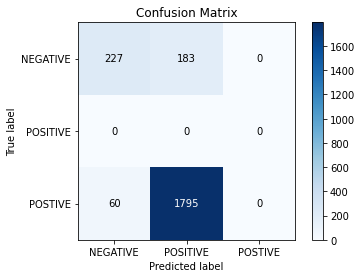

In [92]:
plot_confusion_matrix(test_labels, y_pred)

# Run inference

In [93]:
nlp('I hate this job').cats

{'NEGATIVE': 0.6646435260772705, 'POSITIVE': 0.33535653352737427}

In [94]:
nlp('I love this job').cats

{'NEGATIVE': 1.8739842031962922e-23, 'POSITIVE': 1.0}

In [96]:
# save to disk
nlp.to_disk('.')